# Topology Module example

**Modeling networks of spiking neurons using NEST**

**OCNC summer school 2018, 28.6.2018**

**Espen Hagen - espen.hagen@fys.uio.no**

The topology module provides the NEST simulator with a convenient interface for creating layers of neurons placed in space and connecting neurons in such layers with probabilities and properties depending on the relative placement of neurons. This permits the creation of complex networks with spatial structure.

This notebook gives an overview over the functionality and main commands provided by the topology module. It is a working example which can directly be executed cell by cell. Afterwards, however, you need to play around with the code in order to fully understand what is going on.

Read the documentation of the commands (e.g., **`topo.CreateLayer?`**). Try to create and connect layers with the different provided layer and connection dictionaries and visualize the connections afterwards. Modify the dictionary entries or create your own dictionaries, ...

The definite reference manual on NEST's topology library is **`nest-2.10.0/topology/doc/Topology_UserManual.pdf`**.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nest
import nest.topology as topo # import topology as a submodule of nest
import nest.raster_plot
import numpy as np

In [3]:
nest.ResetKernel()

## Defining layers

At first, we create network layers which contain elements at spatial locations.
The positions of the elements can be either on a regular grid (specify rows and columns) or distributed arbitrarily in the plane (define the exact positions as (x,y) coordinates). The function **`CreateLayer()`** expects a dictionary with the layer specifications. Two possible layer dictionaries are provided

In [4]:
ext = 2. # here we use a square layer of size (ext x ext)


# layer on grid
layer1 = {
    'extent': [ext, ext], # size of the layer
    'rows': 20, # number of rows
    'columns': 20, # number of columns
    'elements': 'iaf_psc_alpha' # element at each (x,y) coordinate in the grid
}


# layer off grid (here: on a grid with jitter)
jit = 0.05
xs = np.linspace(-ext/2.+jit, ext/2.-jit, 20)
poss = [[x,y] for y in xs for x in xs]
poss = [[p[0] + np.random.uniform(-jit, jit), p[1] + np.random.uniform(-jit, jit)] for p in poss]

layer2 = {
    'extent': [ext, ext],
    'positions': poss,
    'elements': 'iaf_psc_alpha'
}

In [5]:
mylayer = topo.CreateLayer(layer1)

We aim at stimulating a subset of neurons with Poissonian noise. Therefore, we create a noise layer in addition to the neuron layer with a poisson generator at its center and set its rate.

In [6]:
# make a copy of the poisson_generator model and specify the rate
nest.CopyModel('poisson_generator', 'my_poisson_generator', {'rate': 80000.} )

noise_layer_dict = {
    'extent': [ext, ext],
    'positions': [[0.0, 0.0]],
    'elements': 'my_poisson_generator'
}

In [7]:
noiselayer = topo.CreateLayer(noise_layer_dict)

## Defining connection profiles

The types of connections between populations of neurons are defined by connection dictionaries. Some basic information:

When connecting two layers, the **`driver`** layer is the one in which each node is considered in turn and the **`pool`** layer is the one from which nodes are chosen for each node in the driver layer.

**`mask`**: which pool nodes are considered as potential targets for each driver node

**`kernel`**: function which returns a (possibly distance- or displacement-dependent) probability for creating a connection between a driver and a pool node

**`autapse`**: a synapse (connection) from a node onto itself

**`edge_wrap`**: if **`True`**, periodic boundary conditions are used (torus connectivity)

The next cell gives four examples for connection dictionaries

In [8]:
# circular mask, gaussian kernel
conn1 = {
    'connection_type': 'divergent', # convergent or divergent
    'mask': {'circular': {'radius': 0.75}},
    'kernel': {'gaussian': {'p_center': 1., 'sigma': 0.25}}, # 
    'allow_autapses': False
}

# Other possibilites of connection kernels:
# rectangular mask, constant kernel, non-centered anchor
conn2 = {
    'connection_type': 'divergent',
    'mask': {'rectangular': {'lower_left': [-0.4, -0.4], 'upper_right': [0.4, 0.4]},
             'anchor': [0.4, 0.4]
             },
    'kernel': 0.75,
    'allow_autapses': False
}

# doughnut mask, linear kernel that decreases with distance
conn3 = {
    'connection_type': 'divergent',
    'mask': {'doughnut': {'inner_radius': 0.3, 'outer_radius': 0.8}},
    'kernel': {'linear': {'c': 1., 'a': -0.9}}
}

# rectangle mask, fixed number of connections, gaussian weights, linear delays
conn4 = {
    'connection_type': 'divergent',
    'mask': {'rectangular': {'lower_left': [-0.5, -0.5], 'upper_right': [0.5, 0.5]}},
    'number_of_connections': 20,
    'weights': {'gaussian': {'p_center': 1.5, 'sigma': 0.25}},
    'delays': {'linear': {'c': 0.1, 'a': 0.2}},
    'allow_autapses': False
}

## Connecting layers

The command **`ConnectLayers()`** expects a source layer, a target layer, and a connection dictionary.

In [9]:
topo.ConnectLayers(noiselayer, mylayer, conn1)

## Visualization

**`PlotLayer()`** plots all nodes of a layer.

**`FindCenterElement()`** returns the GID of the element closest to the center of the layer. 

**`PlotTargets()`** plots all targets of a node in a given layer.

/opt/nest/lib/python3.6/site-packages/nest/lib/hl_api_helper.py:92: UserWarning: 
GetChilden is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


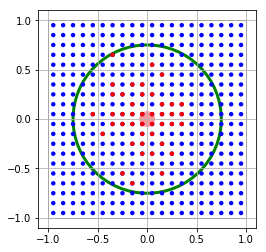

In [10]:
layer = mylayer
conn_dict = conn1

fig = topo.PlotLayer(layer)
ctr = topo.FindCenterElement(noiselayer) # extract GID of poisson generator
topo.PlotTargets(ctr, layer, fig=fig, mask=conn_dict['mask'], mask_color='green',
                 src_size=250, src_color='red',
                 tgt_size=20, tgt_color='red', )
   
# beautify
pylab.axes().set_xticks(pylab.arange(-ext/2., ext/2.+0.5, 0.5))
pylab.axes().set_yticks(pylab.arange(-ext/2., ext/2.+0.5, 0.5))
pylab.grid(True)

## Run simulation and analysis

Before running the simulation, we create a spike detector for recording and connect it to the neurons of mylayer.
Note how the creation and connection routines from nest itself (**`Create()`** and **`Connect()`**) and from the topology module (**`CreateLayer()`** and **`ConnectLayers()`**) differ.

In [11]:
# extract the neuron GIDs from the topology layer
neurons = nest.GetLeaves(mylayer)[0]

spike_detector = nest.Create('spike_detector')

nest.Connect(neurons, spike_detector)

/opt/nest/lib/python3.6/site-packages/nest/lib/hl_api_helper.py:92: UserWarning: 
GetLeaves is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


In [12]:
nest.Simulate(1000.0)

The neurons (y-axis) are sorted according to their IDs when visualizing the spiking output. If a grid layer was used, spatially confined activity can be observed.

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


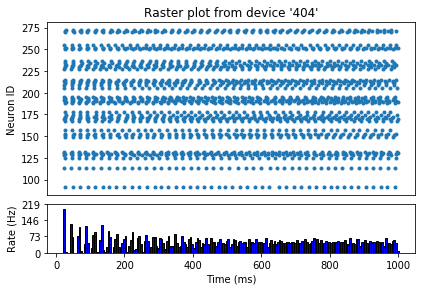

In [13]:
nest.raster_plot.from_device(spike_detector)